## Elk farm

Your family has been managing Washington State's longest-running elk farm for several generations, but for decades the health of your herd has been slowly getting worse. It's a well known fact that your farm's breed of elk shouldn't be fed grain when average nightly temperatures are over freezing (32°F or 0°C). For that reason, you traditionally follow your grandfather's farming calendar and switch from grain feed after January 31.

You recently read about climate change affecting farming practices. Could this change explain the poorer health of your elk in recent years? With some historical weather data at your side, you seek to determine whether local temperatures are changed from your grandfather's day, and whether your farming calendar needs to be updated.

In [1]:
import pandas
!wget https://raw.githubusercontent.com/MicrosoftDocs/mslearn-introduction-to-machine-learning/main/m0b_optimizer.py
!wget https://raw.githubusercontent.com/MicrosoftDocs/mslearn-introduction-to-machine-learning/main/Data/seattleWeather_1948-2017.csv

# Load a file that contains weather data for Seattle
data = pandas.read_csv('seattleWeather_1948-2017.csv', parse_dates=['date'])

# Keep only January temperatures
data = data[[d.month == 1 for d in data.date]].copy()


# Print the first and last few rows
# Remember that with Jupyter notebooks, the last line of
# code is automatically printed
data

--2025-07-07 17:23:31--  https://raw.githubusercontent.com/MicrosoftDocs/mslearn-introduction-to-machine-learning/main/m0b_optimizer.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1287 (1.3K) [text/plain]
Saving to: ‘m0b_optimizer.py’

m0b_optimizer.py    100%[===================>]   1.26K  --.-KB/s    in 0s      

2025-07-07 17:23:31 (54.7 MB/s) - ‘m0b_optimizer.py’ saved [1287/1287]

--2025-07-07 17:23:31--  https://raw.githubusercontent.com/MicrosoftDocs/mslearn-introduction-to-machine-learning/main/Data/seattleWeather_1948-2017.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.110.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connecte

,date,amount_of_precipitation,max_temperature,min_temperature,rain
0,1948-01-01,0.47,51,42,True
1,1948-01-02,0.59,45,36,True
2,1948-01-03,0.42,45,35,True
3,1948-01-04,0.31,45,34,True
4,1948-01-05,0.17,45,32,True
...,...,...,...,...,...
25229,2017-01-27,0.00,54,37,False
25230,2017-01-28,0.00,52,37,False
25231,2017-01-29,0.03,48,37,True
25232,2017-01-30,0.02,45,40,True


/tmp/ipython-input-2-1462090964.py:11: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


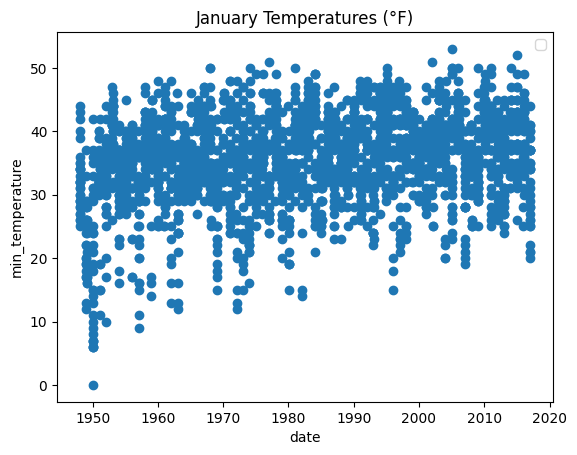

In [2]:
import matplotlib.pyplot as plt

# Let's take a quick look at our data

plt.scatter(data["date"], data["min_temperature"])

# add labels and legend
plt.xlabel("date")
plt.ylabel("min_temperature")
plt.title("January Temperatures (°F)")
plt.legend()

/tmp/ipython-input-3-2008889612.py:18: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


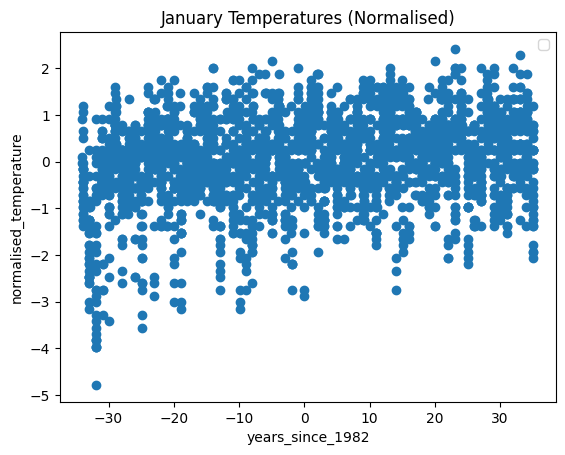

In [3]:
import numpy as np

# This block of code scales and offsets the data slightly, which helps the training process
# You don't need to understand this code. We'll cover these concepts in later learning material

# Offset date into number of years since 1982
data["years_since_1982"] = [(d.year + d.timetuple().tm_yday / 365.25) - 1982 for d in data.date]

# Scale and offset temperature so that it has a smaller range of values
data["normalised_temperature"] = (data["min_temperature"] - np.mean(data["min_temperature"])) / np.std(data["min_temperature"])

# Graph
plt.scatter(data["years_since_1982"], data["normalised_temperature"])
# add labels and legend
plt.xlabel("years_since_1982")
plt.ylabel("normalised_temperature")
plt.title("January Temperatures (Normalised)")
plt.legend()

In [4]:
class MyModel:

    def __init__(self):
        '''
        Creates a new MyModel
        '''
        # Straight lines described by two parameters:
        # The slope is the angle of the line
        self.slope = 0
        # The intercept moves the line up or down
        self.intercept = 0

    def predict(self, date):
        '''
        Estimates the temperature from the date
        '''
        return date * self.slope + self.intercept

# Create our model ready to be trained
model = MyModel()

print("Model made!")

Model made!


Model parameters before training: 0, 0
Model visualised before training:


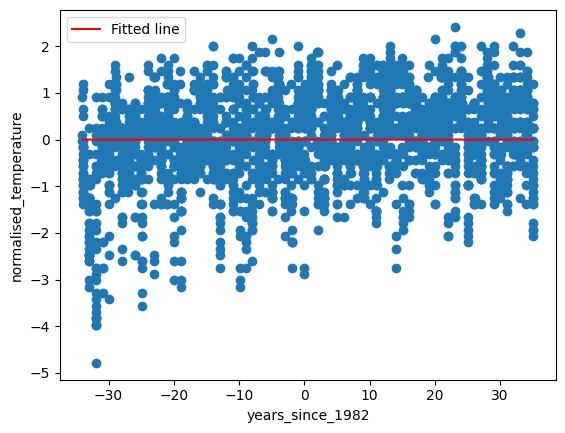

In [5]:
print(f"Model parameters before training: {model.intercept}, {model.slope}")

# Look at how well the model does before training
print("Model visualised before training:")

plt.scatter(data["years_since_1982"], data["normalised_temperature"])
plt.plot(data["years_since_1982"], model.predict(data["years_since_1982"]), 'r', label='Fitted line')


# add labels and legend
plt.xlabel("years_since_1982")
plt.ylabel("normalised_temperature")
plt.legend()

In [6]:
def cost_function(actual_temperatures, estimated_temperatures):
    '''
    Calculates the difference between actual and estimated temperatures
    Returns the difference, and also returns the squared difference (the cost)

    actual_temperatures: One or more temperatures recorded in the past
    estimated_temperatures: Corresponding temperature(s) estimated by the model
    '''

    # Calculate the difference between actual temperatures and those
    # estimated by the model
    difference = estimated_temperatures - actual_temperatures

    # Convert to a single number that tells us how well the model did
    # (smaller numbers are better)
    cost = sum(difference ** 2)

    return difference, cost

In [7]:
from m0b_optimizer import MyOptimizer

# Create an optimizer
optimizer = MyOptimizer()

In [8]:
def train_one_iteration(model_inputs, true_temperatures, last_cost:float):
    '''
    Runs a single iteration of training.


    model_inputs: One or more dates to provide the model (dates)
    true_temperatues: Corresponding temperatures known to occur on those dates

    Returns:
        A Boolean, as to whether training should continue
        The cost calculated (small numbers are better)
    '''

    # === USE THE MODEL ===
    # Estimate temperatures for all data that we have
    estimated_temperatures = model.predict(model_inputs)

    # === OBJECTIVE FUNCTION ===
    # Calculate how well the model is working
    # Smaller numbers are better
    difference, cost = cost_function(true_temperatures, estimated_temperatures)

    # Decide whether to keep training
    # We'll stop if the training is no longer improving the model effectively
    if cost >= last_cost:
        # Stop training
        return False, cost
    else:
        # === OPTIMIZER ===
        # Calculate updates to parameters
        intercept_update, slope_update = optimizer.get_parameter_updates(model_inputs, cost, difference)

        # Change the model parameters
        model.slope += slope_update
        model.intercept += intercept_update

        return True, cost

print("Training method ready")

Training method ready


In [9]:
import math

print(f"Model parameters before training:\t\t{model.intercept:.8f},\t{model.slope:.8f}")

continue_loop, cost = train_one_iteration(model_inputs = data["years_since_1982"],
                                                    true_temperatures = data["normalised_temperature"],
                                                    last_cost = math.inf)

print(f"Model parameters after 1 iteration of training:\t{model.intercept:.8f},\t{model.slope:.8f}")


Model parameters before training:		0.00000000,	0.00000000
Model parameters after 1 iteration of training:	0.00000000,	0.01006832


Training beginning...
Iteration: 0
Iteration: 400
Iteration: 800
Iteration: 1200
Iteration: 1600
Iteration: 2000
Iteration: 2400
Iteration: 2800
Iteration: 3200
Iteration: 3600
Iteration: 4000
Training complete!
Model parameters after training:	-0.00648853,	0.01193327


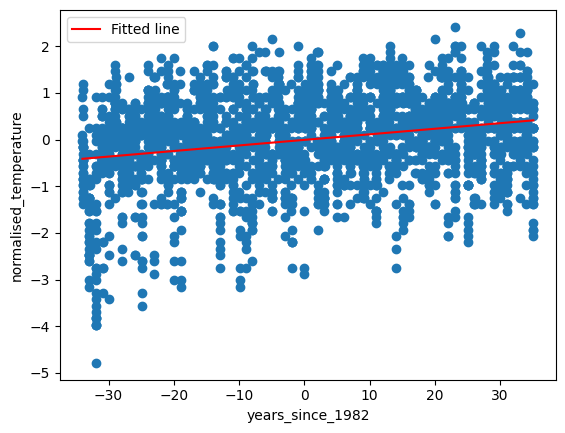

In [10]:

# Start the loop
print("Training beginning...")
last_cost = math.inf
i = 0
continue_loop = True
while continue_loop:

    # Run one iteration of training
    # This will tell us whether to stop training, and also what
    # the cost was for this iteration
    continue_loop, last_cost = train_one_iteration(model_inputs = data["years_since_1982"],
                                                    true_temperatures = data["normalised_temperature"],
                                                    last_cost = last_cost)

    # Print the status
    if i % 400 == 0:
        print("Iteration:", i)

    i += 1


print("Training complete!")
print(f"Model parameters after training:\t{model.intercept:.8f},\t{model.slope:.8f}")

plt.scatter(data["years_since_1982"], data["normalised_temperature"])
plt.plot(data["years_since_1982"], model.predict(data["years_since_1982"]), 'r', label='Fitted line')

# add labels and legend
plt.xlabel("years_since_1982")
plt.ylabel("normalised_temperature")
plt.legend()